In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

from data.load_data import load_data_raw
from data.clean_data import run_cleaning_pipeline
from utils.config_loader import load_config

from data.clean_data import export_and_audit_clean_data

In [2]:

cfg = load_config()
df_raw = load_data_raw(cfg)
df_cleaned = run_cleaning_pipeline(df_raw, cfg)
export_and_audit_clean_data(df_cleaned, cfg)

   [Audit] section_0 : -1752 lignes exportées vers section_0_removed.csv
   [Audit] section_2 : -36 lignes exportées vers section_2_removed.csv
   [Audit] section_3 : -59 lignes exportées vers section_3_removed.csv
   [Audit] section_1 : -108 lignes exportées vers section_1_removed.csv


In [3]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1421 entries, 0 to 3375
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1421 non-null   int64  
 1   DataYear                       1421 non-null   int64  
 2   BuildingType                   1421 non-null   object 
 3   PrimaryPropertyType            1421 non-null   object 
 4   PropertyName                   1421 non-null   object 
 5   Address                        1421 non-null   object 
 6   City                           1421 non-null   object 
 7   State                          1421 non-null   object 
 8   ZipCode                        1421 non-null   float64
 9   TaxParcelIdentificationNumber  1421 non-null   object 
 10  CouncilDistrictCode            1421 non-null   int64  
 11  Neighborhood                   1421 non-null   object 
 12  Latitude                       1421 non-null   float6

In [4]:
df_cleaned.shape

(1421, 44)

In [5]:
# Check missing values in the 'PrimaryPropertyType' column
df_raw['PrimaryPropertyType'].isna().sum()

np.int64(0)

In [6]:
# Sélection des lignes avec LargestPropertyUseType manquant
missing_rows = df_cleaned[df_cleaned['LargestPropertyUseType'].isna()]

# Afficher seulement certaines colonnes utiles
cols_to_show = ['PropertyName', 'PrimaryPropertyType', 'LargestPropertyUseType']
missing_rows[cols_to_show].head()


,PropertyName,PrimaryPropertyType,LargestPropertyUseType


✅ Parfait ! Aucune valeur manquante détectée dans le dataset nettoyé.


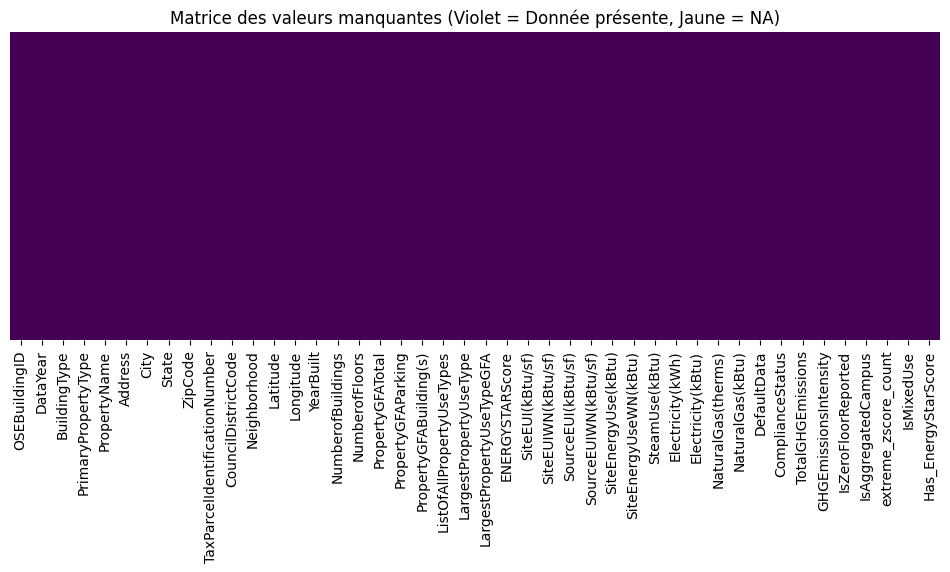

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calcul du taux de remplissage
nan_analysis = df_cleaned.isna().mean() * 100
nan_analysis = nan_analysis[nan_analysis > 0].sort_values(ascending=False)

if nan_analysis.empty:
    print("✅ Parfait ! Aucune valeur manquante détectée dans le dataset nettoyé.")
else:
    print("🔍 Valeurs manquantes restantes (en %) :")
    print(nan_analysis)

# 2. Visualisation de la matrice de complétude
plt.figure(figsize=(12, 4))
sns.heatmap(df_cleaned.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Matrice des valeurs manquantes (Violet = Donnée présente, Jaune = NA)")
plt.show()

--- TEST DE COMPLÉTUDE ---
✅ Succès : Aucune valeur manquante (0 NA).


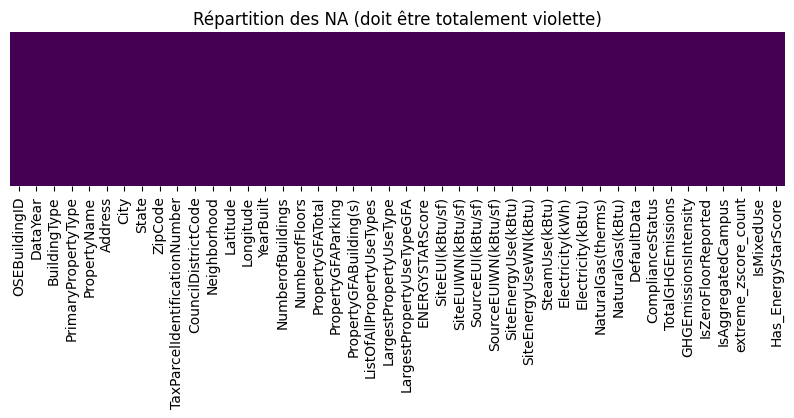

In [8]:
print("--- TEST DE COMPLÉTUDE ---")
missing_counts = df_cleaned.isna().sum()
missing_pct = (missing_counts / len(df_cleaned)) * 100

if missing_counts.sum() == 0:
    print("✅ Succès : Aucune valeur manquante (0 NA).")
else:
    print("⚠️ Attention, valeurs manquantes détectées :")
    print(missing_pct[missing_pct > 0])

# Visualisation rapide
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
sns.heatmap(df_cleaned.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Répartition des NA (doit être totalement violette)")
plt.show()

In [9]:
print("--- TEST DE COHÉRENCE GFA ---")
# Vérification s'il existe des surfaces aberrantes (négatives ou nulles)
invalid_gfa = df_cleaned[df_cleaned['PropertyGFATotal'] <= 0]

if invalid_gfa.empty:
    print(f"✅ Succès : Toutes les surfaces sont positives (Min: {df_cleaned['PropertyGFATotal'].min():,.0f} sqft).")
else:
    print(f"❌ Erreur : {len(invalid_gfa)} lignes ont une surface <= 0.")

# Vérification du ratio Bâtiment / Terrain (si les colonnes existent)
if 'PropertyGFABuilding(s)' in df_cleaned.columns and 'PropertyGFATotal' in df_cleaned.columns:
    ratio = df_cleaned['PropertyGFABuilding(s)'] / df_cleaned['PropertyGFATotal']
    print(f"📊 Ratio moyen Bâtiment/Total : {ratio.mean():.2f}")

--- TEST DE COHÉRENCE GFA ---
✅ Succès : Toutes les surfaces sont positives (Min: 11,285 sqft).
📊 Ratio moyen Bâtiment/Total : 0.94


In [10]:
# Extraire les campus
campus_floors = df_cleaned.loc[df_cleaned['IsAggregatedCampus'] == 1, 'NumberofFloors']

# Comptage des valeurs non nulles
non_zero_count = (campus_floors > 0).sum()
print(f"Nombre de campus avec étages non nuls : {non_zero_count} / {len(campus_floors)}")

# Distribution des valeurs positives
distribution = campus_floors[campus_floors > 0].value_counts().sort_index()
print("\n--- Distribution des étages (Campus, >0) ---")
print(distribution)

# Pourcentage de 1 étage
pct_one_floor = (campus_floors == 1).sum() / len(campus_floors) * 100
print(f"\nProportion de campus avec exactement 1 étage : {pct_one_floor:.1f}%")


Nombre de campus avec étages non nuls : 20 / 20

--- Distribution des étages (Campus, >0) ---
NumberofFloors
1      4
2     12
3      1
4      2
10     1
Name: count, dtype: int64

Proportion de campus avec exactement 1 étage : 20.0%


In [11]:
print("--- VÉRIFICATION FILTRAGE OUTLIERS ---")

# 1. Vérification des Flags IQR
# On vérifie qu'il n'y a plus AUCUN bâtiment marqué comme outlier d'intensité
cols_check = ['is_outlier_iqr_SiteEUI(kBtu/sf)', 'is_outlier_iqr_GHGEmissionsIntensity']
remaining_outliers = df_cleaned[cols_check].sum().sum()

if remaining_outliers == 0:
    print("✅ Succès : Les outliers d'intensité thermodynamique ont été totalement supprimés.")
else:
    print(f"⚠️ Alerte : Il reste {remaining_outliers} outliers marqués dans le dataset.")

# 2. Vérification des Surfaces Massives (Ta décision métier)
# On vérifie qu'on a bien gardé les hôpitaux ou universités même s'ils sont très grands
massive_types = cfg.cleaning.section_3.massive_structures_types
massive_preserved = df_cleaned[df_cleaned['PrimaryPropertyType'].isin(massive_types)]
print(f"🏢 Structures massives conservées (Hôpitaux, Univ, etc.) : {len(massive_preserved)} lignes.")

--- VÉRIFICATION FILTRAGE OUTLIERS ---


KeyError: "None of [Index(['is_outlier_iqr_SiteEUI(kBtu/sf)', 'is_outlier_iqr_GHGEmissionsIntensity'], dtype='object')] are in the [columns]"

In [ ]:
import numpy as np
print("--- PRÉCISION DU RECALCUL EUI (LOGIQUE SEATTLE) ---")

# On utilise la même référence que dans le pipeline : PropertyGFABuilding(s)
df_test = df_cleaned.copy()

# On s'assure de ne pas diviser par zéro si la colonne building GFA est manquante ou nulle
surface_col = 'PropertyGFABuilding(s)' 

df_test['recalc_EUI'] = df_test['SiteEnergyUseWN(kBtu)'] / df_test[surface_col]
df_test['diff_eui'] = (df_test['recalc_EUI'] - df_test['SiteEUIWN(kBtu/sf)']).abs()

# On ignore les éventuels NaN/Inf pour le calcul de la moyenne
mae_eui = df_test['diff_eui'].replace([np.inf, -np.inf], np.nan).dropna().mean()

print(f"📉 Erreur Moyenne Absolue (MAE) sur EUI : {mae_eui:.6f}")

if mae_eui < 0.001:
    print("✅ Le recalcul est parfaitement précis avec PropertyGFABuilding(s).")
else:
    print(f"⚠️ Écart de {mae_eui:.4f}. Vérifie si certains bâtiments n'utilisent pas encore le Total GFA.")

--- PRÉCISION DU RECALCUL EUI (LOGIQUE SEATTLE) ---
📉 Erreur Moyenne Absolue (MAE) sur EUI : 0.000000
✅ Le recalcul est parfaitement précis avec PropertyGFABuilding(s).


In [ ]:
print("🔍 INVESTIGATION DES SURFACES")

df_check = df_cleaned.copy()
# Test avec Total GFA
df_check['eui_total'] = df_check['SiteEnergyUseWN(kBtu)'] / df_check['PropertyGFATotal']
# Test avec Building GFA
df_check['eui_bldg'] = df_check['SiteEnergyUseWN(kBtu)'] / df_check['PropertyGFABuilding(s)']

mae_total = (df_check['eui_total'] - df_check['SiteEUIWN(kBtu/sf)']).abs().mean()
mae_bldg = (df_check['eui_bldg'] - df_check['SiteEUIWN(kBtu/sf)']).abs().mean()

print(f"MAE avec PropertyGFATotal : {mae_total:.4f}")
print(f"MAE avec PropertyGFABuilding(s) : {mae_bldg:.4f}")

if mae_bldg < mae_total:
    print("✅ Le calcul de Seattle utilise la surface du bâtiment (Building GFA) et non la surface totale.")

🔍 INVESTIGATION DES SURFACES
MAE avec PropertyGFATotal : 6.3071
MAE avec PropertyGFABuilding(s) : 0.0000
✅ Le calcul de Seattle utilise la surface du bâtiment (Building GFA) et non la surface totale.


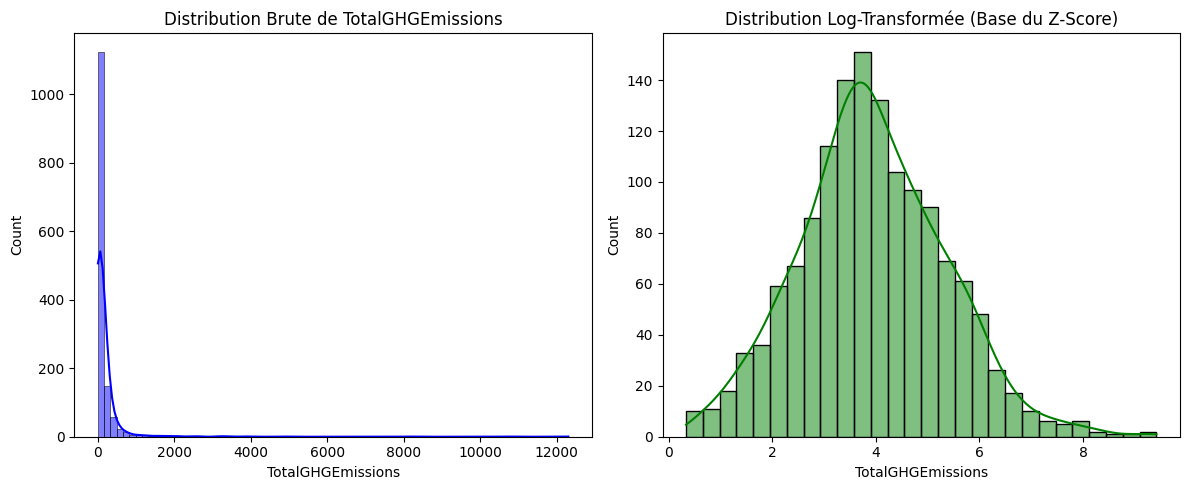

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

target_col = 'TotalGHGEmissions'

plt.figure(figsize=(12, 5))

# Distribution Brute
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned[target_col], kde=True, color='blue')
plt.title(f"Distribution Brute de {target_col}")

# Distribution Log
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_cleaned[target_col]), kde=True, color='green')
plt.title(f"Distribution Log-Transformée (Base du Z-Score)")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# 1. Chargement brut sans aucun traitement
df_raw = pd.read_csv('../data/raw/2016_Building_Energy_Benchmarking.csv')

# 2. Analyse des incohérences (Consommation présente mais EUI manquant ou nul)
# On vérifie les cas où l'énergie est renseignée (> 0) 
# MAIS où l'EUI est soit nul, soit absent (NaN)
mask_incoherent = (df_raw['SiteEnergyUseWN(kBtu)'] > 0) & \
                  ((df_raw['SiteEUIWN(kBtu/sf)'].isna()) | (df_raw['SiteEUIWN(kBtu/sf)'] == 0))

nb_anomalies = mask_incoherent.sum()

print(f"🔍 ANALYSE DU DATASET SOURCE")
print(f"Nombre total de lignes : {len(df_raw)}")
print(f"Bâtiments avec énergie déclarée mais EUI manquant/nul : {nb_anomalies}")

# 3. Affichage des colonnes pour comprendre l'absence de calcul
if nb_anomalies > 0:
    print("\nÉchantillon des bâtiments nécessitant un recalcul :")
    cols = ['OSEBuildingID', 'PrimaryPropertyType', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)']
    display(df_raw[mask_incoherent][cols].head(10))

🔍 ANALYSE DU DATASET SOURCE
Nombre total de lignes : 3376
Bâtiments avec énergie déclarée mais EUI manquant/nul : 0
